In [2]:
# Auteur : Sylvain Brisson (Mines Paris)

import pandas as pd 
pd.options.plotting.backend = 'plotly'

import numpy as np
from scipy.interpolate import interp1d

import plotly.graph_objects as go
import matplotlib.pyplot as plt

import matplotlib.colors as colors
import matplotlib.cm as cmx

from matplotlib import ticker

plt.rcParams["figure.figsize"] = (8,6)
plt.rcParams.update({'font.size': 18,'legend.fontsize':15})
plt.rcParams['savefig.pad_inches'] = 0.1


In [3]:
# Production historique ICSG 
# Copper Factbook 2023 https://icsg.org/copper-factbook/
df_hist_icsg = pd.read_csv("./data/ICSG_historical_data_1960_2022.csv").set_index("Year")
df_hist_icsg.head()

,Cu supply (Mt),Cu primary production (Mt)
Year,,
1960,4.426,3.721
1961,4.564,3.798
1962,4.702,3.877
1963,4.886,4.058
1964,5.071,4.365


In [4]:
# Production historique USGS
df_hist_usgs = pd.read_csv("./data/USGS_historical_supply_1900_2023.csv").set_index("Year")
df_hist_usgs.head()

,Cu supply (Mt)
Year,
1900,0.48
1901,0.50
1902,0.52
1903,0.54
1904,0.56


In [5]:
# D'après Schipper et al. 2018 https://doi.org/10.1016/j.resconrec.2018.01.004
df_futur = pd.read_csv("./data/total_supply_future_Schipper_2018.csv").set_index("Year")
df_futur.head()

,Cu supply (Mt)
Year,
2020,30.90
2025,36.10
2030,41.48
2035,47.14
2040,52.42


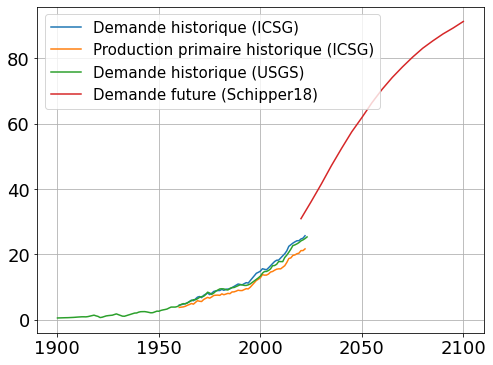

In [6]:
# Plot des données

plt.plot(df_hist_icsg.index, df_hist_icsg["Cu supply (Mt)"], label="Demande historique (ICSG)")
plt.plot(df_hist_icsg.index, df_hist_icsg["Cu primary production (Mt)"], label="Production primaire historique (ICSG)")
plt.plot(df_hist_usgs.index, df_hist_usgs["Cu supply (Mt)"], label="Demande historique (USGS)")
plt.plot(df_futur.index, df_futur["Cu supply (Mt)"], label="Demande future (Schipper18)")

plt.grid()
plt.legend()
plt.show()


# Modélisation du recyclage du Cuivre

In [7]:
# Estimation tau et taux de recylage

alpha = np.linspace(0.2,0.8,100)
tau = np.arange(20,60)

t0 = 1980
i0 = t0 - 1960
dt = t0 - 1900

# On utilise la production primaire de l'ICGS 
primary_prod_t0_2022 = df_hist_icsg[df_hist_icsg.index>=t0]["Cu primary production (Mt)"].to_numpy()
demand_t0_2022 = df_hist_icsg[df_hist_icsg.index>=t0]["Cu supply (Mt)"].to_numpy()
demand_1900_t0 = df_hist_usgs[df_hist_usgs.index<t0]["Cu supply (Mt)"].to_numpy()
demand_1900_2022 = np.hstack([demand_1900_t0,demand_t0_2022])

# On calcule la production primaire théorique 
th_primary_prod = np.zeros((len(alpha),len(tau),len(primary_prod_t0_2022)))
for i in range(len(alpha)):
    for j in range(len(tau)):
        th_primary_prod[i,j,:] = demand_t0_2022 - alpha[i] * demand_1900_2022[dt-tau[j]:-tau[j]]
        
# On calcule l'erreur de prediction
error = np.sqrt(np.square(th_primary_prod - primary_prod_t0_2022).sum(axis=2))
i_alpha,i_tau = np.unravel_index(error.argmin(), error.shape)

print("Résultat inversion moindres carrés :")
print(f"Taux de recyclage = {alpha[i_alpha]*100:.1f}%")
print(f"Temps de résidence = {tau[i_tau]} ans")

Résultat inversion moindres carrés :
Taux de recyclage = 43.0%
Temps de résidence = 37 ans


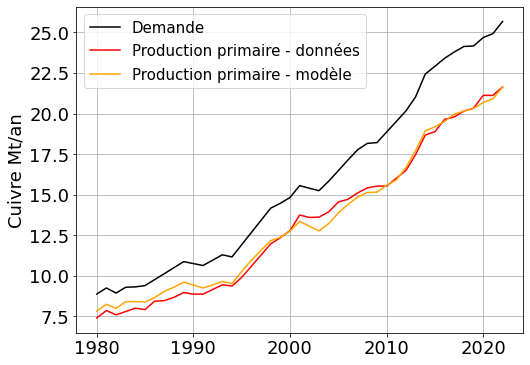

In [8]:
# Plot du meilleur fit 

temps = np.arange(t0,2023)
plt.plot(temps, demand_t0_2022,'k', label="Demande")
plt.plot(temps, primary_prod_t0_2022,'r', label="Production primaire - données")
plt.plot(temps, th_primary_prod[i_alpha,i_tau,:],c='orange', label="Production primaire - modèle")
plt.grid()
plt.ylabel("Cuivre Mt/an")
plt.legend()

plt.savefig("./figures/application_modele_cuivre.png",dpi=200)
plt.show()

# Etude prospective de la consommation de Cuivre

In [9]:
# Scénario de demande total
# On choisit de ne prendre la projection qu'à partir de 2030, on interpole linéairement entre
df_futur_b = df_futur[df_futur.index>=2030]

year_raw = np.concatenate((df_hist_usgs.index.to_numpy(),df_futur_b.index.to_numpy()))
cu_demand_raw = np.concatenate((df_hist_usgs["Cu supply (Mt)"].to_numpy(),df_futur_b["Cu supply (Mt)"].to_numpy()))

# Interpolation linéaire
f = interp1d(year_raw, cu_demand_raw, kind='linear', fill_value="extrapolate")
year = np.arange(1940,2100)
cu_demand_linear = f(year)

# fit d'un polynome de degré N
N = 6
coefficients = np.polyfit(year_raw, cu_demand_raw, N)
poly_function = np.poly1d(coefficients)
cu_demand_poly = poly_function(year)

# spline
spline_interpolation = interp1d(year_raw, cu_demand_raw, kind='cubic')
cu_demand_lag = spline_interpolation(year)

# Plot
fig = go.Figure()
fig.add_trace(go.Scatter(x=year_raw, y=cu_demand_raw, mode='markers'))
fig.add_trace(go.Scatter(x=year, y=cu_demand_linear, mode='lines'))
# fig.add_trace(go.Scatter(x=year, y=cu_demand_poly, mode='lines'))
# fig.add_trace(go.Scatter(x=year, y=cu_demand_lag, mode='lines'))


In [10]:
# On garde le modèle en interpolation cubique
cu_demand = cu_demand_linear

# On prend les taux trouvés précedemment
taux_recy = 0.43
tps_res = 37

p_II = taux_recy * cu_demand[:-tps_res]
p_I = cu_demand[tps_res:] - p_II

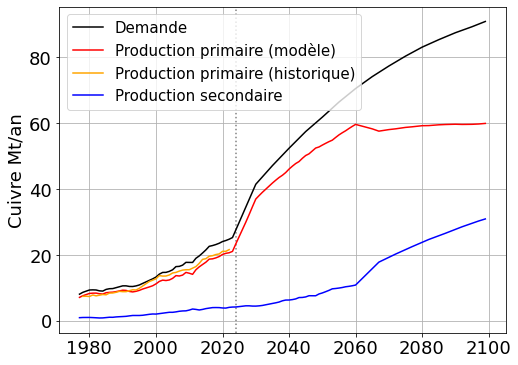

In [11]:
# Plot des données

plt.axvline(2024,color="gray",ls=":")

# Demande modèle
plt.plot(year[tps_res:],cu_demand[tps_res:],"k",label="Demande")

# Résultats modélisation
plt.plot(year[tps_res:], p_I, 'r', label="Production primaire (modèle)")
# Production primaire historique
df_tmp = df_hist_icsg[df_hist_icsg.index > 1940+tps_res]
plt.plot(df_tmp.index,df_tmp["Cu primary production (Mt)"],c="orange",label='Production primaire (historique)')

plt.plot(year[tps_res:], p_II, 'b', label="Production secondaire")

plt.grid()
plt.ylabel("Cuivre Mt/an")
plt.legend()
plt.savefig("./figures/prospective_cuivre_1.png",dpi=200)

plt.show()


In [12]:
import matplotlib.colors as colors
import matplotlib.cm as cmx

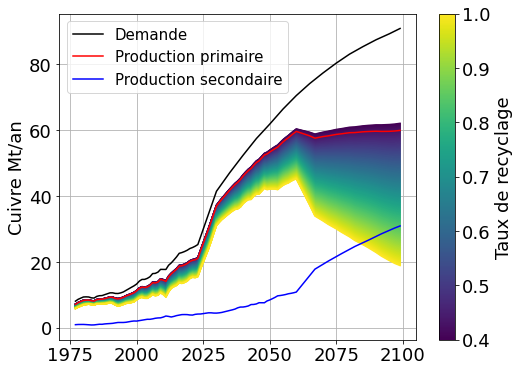

In [13]:
# Ajout de random : on tire le taux de recyclage parmi une normale 
N = 200

tr = np.linspace(0.4,1.,N)
color_map = cmx.ScalarMappable(norm=colors.Normalize(vmin=0.4, vmax=1.), cmap='viridis')


p_I_rd = cu_demand[tps_res:] - np.outer(tr,cu_demand[:-tps_res])

for n in range(N):
    plt.plot(year[tps_res:],p_I_rd[n,:],color=color_map.to_rgba(tr[n]))
    
plt.plot(year[tps_res:],cu_demand[tps_res:],"k",label="Demande")
plt.plot(year[tps_res:],p_I,"r",label="Production primaire")
plt.plot(year[tps_res:], p_II, 'b', label="Production secondaire")


plt.colorbar(color_map,ax=plt.gca(), label="Taux de recyclage")
    
plt.ylabel("Cuivre Mt/an")
plt.legend()
plt.grid()

plt.savefig("./figures/prospective_cuivre_2.png",dpi=200)



# Modèle conceptuel

On a pour toute année $n$ : $D_n = P^I_n + P^{II}_n$
On connaît $D_n$, on cherche à modèliser $P^{II}_n$

**Premier modèle :**

$$
P^{II}_n = \alpha D_{n-M}
$$

Avec $\alpha$ le taux de recyclage, $M$ le nombre d'année d'immobilisation du Cuivre.
Tout le cuivre est remobilisé après $M$ année d'utilisation.

**Second modèle (non implémenté) :**

Décomission lissée du cuivre : taux de décommision $\gamma$ suit une loi normale :
$$
\gamma(t) = \frac{1}{\sigma \sqrt{2\pi}}\exp \left[ -\frac{(t-\tau)^2}{2\sigma^2} \right]
$$

On a ainsi : 
$$
P^{II}_n = \alpha\sum_{m=0}^{n-1}D_m \gamma_{n-m}
$$


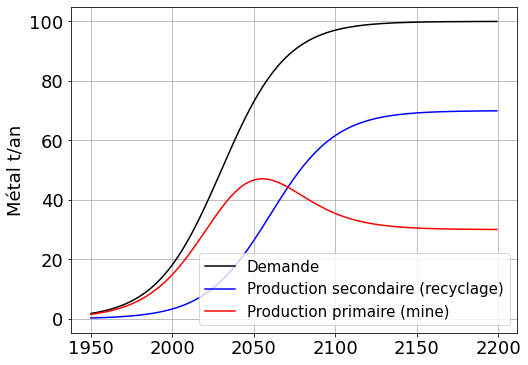

In [14]:
# demande synthétique 1 : croissance perpétuelle avec 

d_inf = 100.
sigma = 5e-2 
t_center = 2030.
taux_recy = 0.7
tps_res = 30

d = lambda t : d_inf / (1 + np.exp(-sigma * (t-t_center)))
p_II = lambda t : taux_recy * d(t-tps_res)
p_I = lambda t : d(t) - p_II(t)


time = np.arange(1950,2200)

plt.plot(time,d(time),"k",label="Demande")
plt.plot(time,p_II(time),"b",label="Production secondaire (recyclage)")
plt.plot(time,p_I(time),"r",label="Production primaire (mine)")
plt.ylabel("Métal t/an")
plt.legend()
plt.grid()

plt.savefig("./figures/demande_synthetique_1.png",dpi=200)


In [15]:
# Calcul du max de la production minière selon tau et tr
time = np.arange(2000,2100)

d = lambda t : d_inf / (1 + np.exp(-sigma * (t-t_center)))
p_II = lambda t,tr,tau : tr * d(t-tau)
p_I = lambda t,tr,tau : d(t) - p_II(t,tr,tau)

p_Imax = np.zeros((100,100))

tau_ = np.linspace(10,100,100)
tr_ = np.linspace(0.0,1.0,100)

for i,tau in enumerate(tau_):
    for j,tr in enumerate(tr_):
        p_Imax[i,j] = np.max(p_I(time,tr,tau))
        

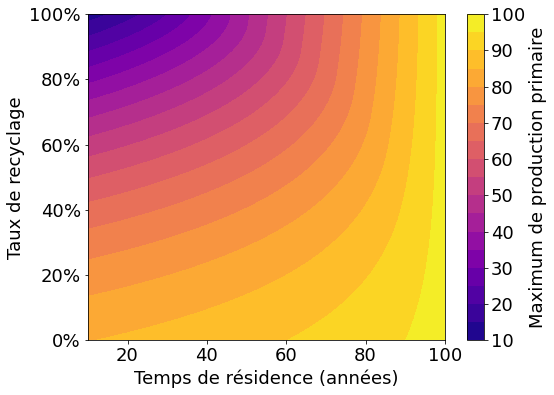

In [16]:
cmap = plt.contourf(tau_,tr_*100,p_Imax[::-1,::-1],levels=20,cmap="plasma")
plt.colorbar(cmap,label="Maximum de production primaire")
plt.gca().yaxis.set_major_formatter(ticker.PercentFormatter())
plt.xlabel("Temps de résidence (années)")
plt.ylabel("Taux de recyclage")

plt.savefig("./figures/maximum_production_map.png",dpi=200)
